In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from scipy import io
import time


In [34]:
def get_data(filename, ndata):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29
    r = 15
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float64) #* 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float64) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    #x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x_branch, y, grid

X_train, y_train, grid = get_data("piececonst_r421_N1024_smooth1.mat", 800)
X_test, y_test, grid = get_data("piececonst_r421_N1024_smooth2.mat", 200)

In [35]:
print(X_train.shape)

(800, 841)


In [36]:
def mse_relative(y_true, y_pred):
    """
    :param y_true:
    :param y_pred:
    :return: average relative mse
    """
    # Handle y_true is zero
    non_zero_mask = y_true != 0
    return np.mean(np.square(np.linalg.norm(y_true[non_zero_mask] - y_pred[non_zero_mask], axis=-1) / np.linalg.norm(y_true[non_zero_mask], axis=-1)))

# X_train, y_train, X_test, y_test, _ = get_data(8000, 2000)

# Framework Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.99999)),
    ('poly_features', PolynomialFeatures(2)),
    ('regression', Ridge())
])

# Parameters for Grid Search
param_grid = {
    'regression__alpha': [1,2]
}

# Custom scorer for grid search
custom_scorer = make_scorer(mse_relative, greater_is_better=False)

# Grid search CV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation relative MSE score:", -grid_search.best_score_)

# Evaluate on test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
relative_mse = mse_relative(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print(f"Relative Mean Squared Error: {relative_mse}")
print(f"Test Mean Squared Error: {mse}")

Best parameters: {'regression__alpha': 1}
Best cross-validation relative MSE score: 0.03019091685596112
Relative Mean Squared Error: 0.025372431835693734
Test Mean Squared Error: 0.011164585250631572


In [37]:
grid.shape

(841, 2)

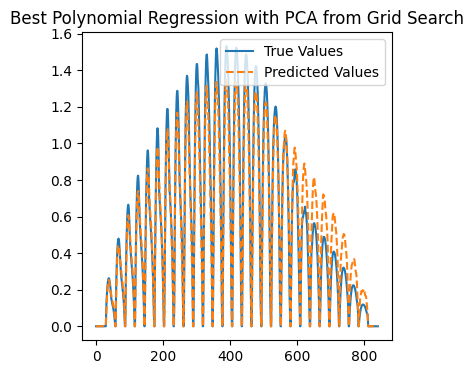

In [38]:
# Plot
plt.figure(figsize=(4, 4))
plt.plot(y_test[100], label='True Values')
plt.plot(predictions[100], label='Predicted Values', linestyle='--')
plt.legend()
plt.title("Best Polynomial Regression with PCA from Grid Search")
plt.show()

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_41310/4281847935.py:6: RuntimeWarning: invalid value encountered in divide
  axs[3].imshow(np.sqrt((y_test[20]-predictions[20])**2/(y_test[20])**2).reshape(29,29), cmap="coolwarm")


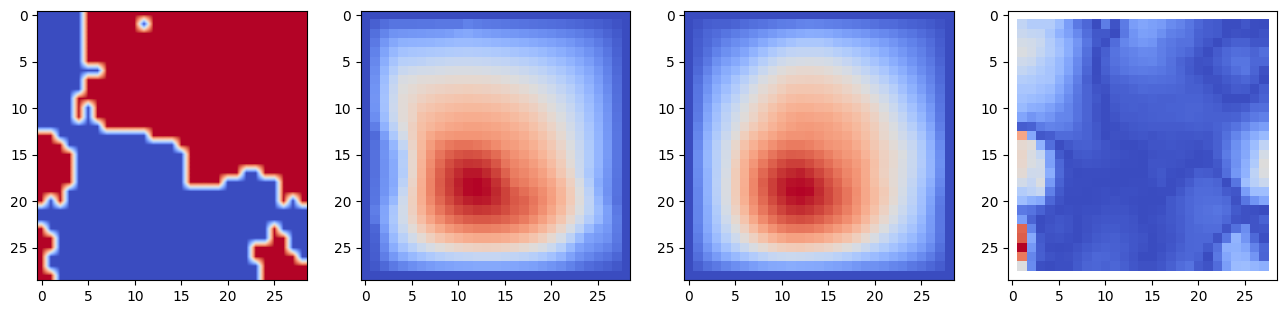

In [46]:
ind = 20
fig, axs = plt.subplots(1,4, figsize=(4*4,4))
axs[0].imshow(X_test[ind].reshape(29,29), interpolation='bilinear', cmap="coolwarm")
axs[1].imshow(y_test[ind].reshape(29,29), cmap="coolwarm")
axs[2].imshow(predictions[ind].reshape(29,29), cmap="coolwarm")
axs[3].imshow(np.sqrt((y_test[20]-predictions[20])**2/(y_test[20])**2).reshape(29,29), cmap="coolwarm")
plt.show()